In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from implicit.datasets.lastfm import get_lastfm
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight
from surprise import Dataset, NormalPredictor, Reader, accuracy, SVD
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split, KFold
from collections import defaultdict
from surprise.prediction_algorithms import KNNBasic, SlopeOne
from sklearn.metrics import ndcg_score
from sklearn.model_selection import LeaveOneOut

In [4]:
#load dataset from implicit
artists, users, plays = get_lastfm()

In [5]:
#вирішив викорстита більш оригінальний датасет, але коли почав з ним працювати зрозумів, що він дуже великий, 
#і обчислюється досить довго, тому використав лише семпл з нього
print(len(artists))
print(len(users))
plays.shape

292385
358868


(292385, 358868)

In [6]:
#convert data into rating score 
plays = bm25_weight(plays, K1=100, B=0.8)

In [7]:
#max and min score
plays_coo = plays.tocoo()
print('max score ', plays_coo.max())
print('min score ', plays_coo.min())

max score  1175.5418122047477
min score  0.0


In [8]:
#convert to pandas
data = pd.Series.sparse.from_coo(plays_coo).reset_index()
data.columns = ('artist', 'user', 'rating')
data.sample(5)

,artist,user,rating
2840458,60442,229199,1.854471
13524402,232725,264341,9.914631
5381189,110375,205327,24.440371
5899541,118421,111052,35.793097
14904867,252512,83215,1.714201


In [9]:
artist_gb = data.groupby('artist')['user'].count()

<Axes: ylabel='Frequency'>

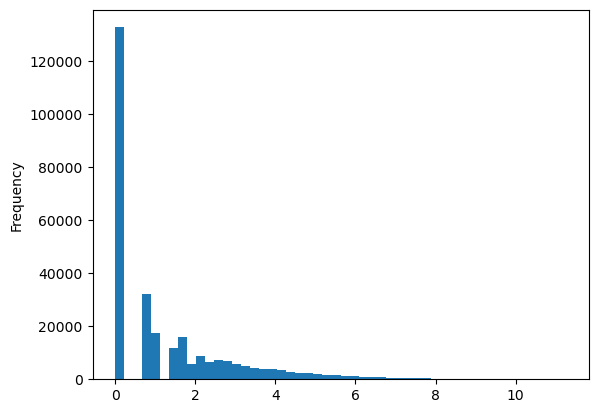

In [10]:
#dist of artists
np.log(artist_gb).plot.hist(bins=50)

In [11]:
#drop low frequency artists
data = data[data['artist'].isin(artist_gb[artist_gb>5000].index)]

In [12]:
#sample 3% of users
users_gb = data.groupby('user')['artist'].count()
users_gb = users_gb.sample(frac=0.03, random_state=42)
data = data[data['user'].isin(users_gb.index)]

In [13]:
print('length of data:', len(data))

length of data: 197417


In [14]:
#convert data to Suprise dataset 
reader = Reader(rating_scale=(0, 1176))
dataset = Dataset.load_from_df(data[['user', 'artist', 'rating']], reader)
#split dataset to train and test by Surprise method
trainset, testset = train_test_split(dataset, test_size=0.25)

In [15]:
#antitrainset to find rank of all items for all users but not only for  those from train and test
antitrainset = trainset.build_anti_testset()

In [16]:
#popularity rating as baseline recomendation
popularity = data.groupby('artist')['user'].agg(['count']).reset_index()
popularity.columns = ['iid', 'rating']

In [17]:
#top50 most popular artists
top_50 = np.asarray(popularity.sort_values('rating', ascending=False).head(50))

In [18]:
algo = SlopeOne() # NormalPredictor(), SVD(), KNNBasic()
# Train the algorithm on the trainset, and predict ratings for the testset and antitrainset
algo.fit(trainset)
predictions = algo.test(testset)
predictions_anti = algo.test(antitrainset)

accuracy.rmse(predictions)

RMSE: 17.5385


17.538546021742597

In [19]:
#ndcg for model (testset)
preds = pd.DataFrame(predictions)
uid_cnt = preds.groupby('uid')['est'].count()
preds = preds[preds['uid'].isin(uid_cnt[uid_cnt>1].index)]

ndcg = []
for uid in preds['uid'].unique():
    df = preds.loc[preds['uid'] == uid]
    true_relevance = np.asarray([list(df['r_ui'])])
    scores = np.asarray([list(df['est'])])
    ndcg.append(ndcg_score(true_relevance, scores))
np.mean(ndcg)

0.9150299420524285

In [20]:
preds = pd.merge(left = preds, right = popularity, how = 'left', on = 'iid')

In [21]:
#ndcg for baseline (testset)
ndcg = []
for uid in preds['uid'].unique():
    df = preds.loc[preds['uid'] == uid]
    true_relevance = np.asarray([list(df['r_ui'])])
    scores = np.asarray([list(df['rating'])])
    ndcg.append(ndcg_score(true_relevance, scores))
np.mean(ndcg)

0.7035684035813634

In [22]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [23]:
#precision and recall for testset
precisions, recalls = precision_recall_at_k(predictions, k=50, threshold=3)
print(sum(prec for prec in precisions.values()) / len(precisions))
print(sum(rec for rec in recalls.values()) / len(recalls))

0.665098671495857
0.7131857835798636


In [24]:
preds_anti = pd.DataFrame(predictions_anti)

In [25]:
preds_anti = pd.merge(left = preds_anti, 
                           right = preds[['uid', 'iid', 'r_ui']],
                           how = 'left',
                           on = ['uid', 'iid']
                          )
preds_anti['r_ui_y'].loc[preds_anti['r_ui_y'].isna()] = 0
preds_anti.head()

/var/folders/lr/w46g2hz506bgx6h0sb6v8_280000gp/T/ipykernel_4262/1293116300.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preds_anti['r_ui_y'].loc[preds_anti['r_ui_y'].isna()] = 0


,uid,iid,r_ui_x,est,details,r_ui_y
0,146338,269151,11.317644,0.187199,{'was_impossible': False},0.0
1,146338,57504,11.317644,11.058221,{'was_impossible': False},0.0
2,146338,258289,11.317644,6.375934,{'was_impossible': False},0.0
3,146338,151370,11.317644,20.064352,{'was_impossible': False},0.0
4,146338,136825,11.317644,15.640393,{'was_impossible': False},0.0


In [26]:
uid_cnt_anti = preds_anti.groupby('uid')['iid'].count()

In [27]:
preds_anti = pd.merge(left = preds_anti, right = popularity, how = 'left', on = 'iid')
preds_anti = preds_anti[preds_anti['uid'].isin(uid_cnt_anti[uid_cnt_anti>1].index)]

In [28]:
#ndcg, k=100, model
ndcg = []
for uid in preds_anti['uid'].unique():
    df = preds_anti.loc[preds_anti['uid'] == uid]
    true_relevance = np.asarray([list(df['r_ui_y'])])
    scores = np.asarray([list(df['est'])])
    ndcg.append(ndcg_score(true_relevance, scores,k=100))
print('\nModel NDCG(k=100): ', np.mean(ndcg))


Model NDCG(k=100):  0.03163050797417398


In [29]:
#ndcg, k=100, baseline
ndcg = []
for uid in preds_anti['uid'].unique():
    df = preds_anti.loc[preds_anti['uid'] == uid]
    true_relevance = np.asarray([list(df['r_ui_y'])])
    scores = np.asarray([list(df['rating'])])
    ndcg.append(ndcg_score(true_relevance, scores,k=100))
print('\nBaseline NDCG(k=100): ', np.mean(ndcg))


Baseline NDCG(k=100):  0.05978736180040191


In [30]:
def GetTopN(predictions, n=10, minimumRating=0.0):
    """
    find top N recommendations
    """
    topN = defaultdict(list)
    for userID, movieID, actualRating, estimatedRating, _ in predictions:
        if (estimatedRating >= minimumRating):
            topN[int(userID)].append((int(movieID), estimatedRating))

    for userID, ratings in topN.items():
        ratings.sort(key=lambda x: x[1], reverse=True)
        topN[int(userID)] = ratings[:n]

    return topN

In [31]:
#top 50 recommendations
topNPredicted = GetTopN(predictions_anti, n=50)     

In [32]:
#top 50 most popular(baseline)
topNbaseline = defaultdict(list)
for userID, _, _, _, _ in predictions_anti:
    topNbaseline[int(userID)] = top_50         

In [33]:
#hitrate 
def HitRate(topNPredicted, leftOutPredictions):
    hits = 0
    total = 0

    for leftOut in leftOutPredictions:
        userID = leftOut[0]
        leftOutMovieID = leftOut[1]
        hit = False
        for movieID, predictedRating in topNPredicted[int(userID)]:
            if (int(leftOutMovieID) == int(movieID)):
                hit = True
                break
        if (hit) :
            hits += 1

        total += 1

    return hits/total
print('\nBaseline Hit Rate: ', HitRate(topNbaseline, predictions))
print('\nModel Hit Rate: ', HitRate(topNPredicted, predictions))


Baseline Hit Rate:  0.250552122378685

Model Hit Rate:  0.036348900820585554


In [34]:
artist_pb = data.groupby('artist')['user'].count() 

In [35]:
#novelty for baseline
novelty_list = []
for uid in topNbaseline:
    for artist, _ in topNbaseline[uid]:
        novelty_list.append(1/(np.log2(1+artist_pb[artist])))
np.mean(novelty_list)
print('\nBaseline Novelty: ', np.mean(novelty_list))

#novelty for model
novelty_list = []
for uid in topNPredicted:
    for artist, _ in topNPredicted[uid]:
        novelty_list.append(1/(np.log2(1+artist_pb[artist])))
print('\nModel Novelty: ', np.mean(novelty_list))


Baseline Novelty:  0.10103285282052335

Model Novelty:  0.13400081596925406
